# Training LLMs - Fine Tuning Language Model on Semantic Tasks

In this assignment we are going to fine tune an off the shelf pre-trained language model to understand semantic similarity. To do this we are going to use the Glue - MSRC dataset provided by microsoft to understand such semantics.

The goal for this assignment is to take an off the shelf language model that is already pre-trained and fine tune it on the task understanding semantic analysis. The languge model that we are going to use is the base `roberta` model that is larger than the original base `bert` model. There are other modifications that `roberta` did to enhance `bert` such as dynamic masking, the removal of the next sentence prediction task, as well as a more enhanced tokenzer.

This assignment will walk you through the steps needed to accomplish this task. You will be asked to fill in the various code blocks as we progress through the notebook. Please view the comments to monitor which code blocks to complete.

In [1]:
# let's first install the various libraries that we'll
# need for this assignment
!pip install -q peft datasets evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-

In [2]:
! pip install transformers[torch]

In [3]:
# we are going to import
# the various methods and classes that we will use
# throughout the notebook.
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType
    )
from datasets import load_dataset
import evaluate
import torch
import numpy as np

# we are going to pull in the RoBERTA model
# which is a modification of BERT
model_name_or_path = "roberta-base"
# this is going to be the specific dataset that
# we are pulling from load dataset.
# this data allows us to understand
# semantic similarity between documents.
task = "mrpc" # microsoft research paraphrase corpus

In [4]:
# let's load in the glue dataset with the MRPC task
dataset = load_dataset("glue", task)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [5]:
# let's view the data set as a whole
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [6]:
# look at a few records of the train dataset.
# label refers to if those sentences are indeed
# similar

## code here
dataset['train'][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

As is typical when fine tuning language models, we need to create a function that will keep track of metrics while training. In order to do this we are going to use the native metric that is seen in the GLEU dataset creation.

For more information on the GLUE Metric and Datasets, please view this link: [GLEU](https://huggingface.co/spaces/evaluate-metric/glue).

In [7]:
# at this point we are going to load in the metric
# that we should be using when evaluating the MRPC dataset.
# we will use this as part of computing metrics
metric = evaluate.load("glue", task)

In [8]:
# let's visualize what this metric
# looks like.
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

In [9]:
# we can see an example here
# between references and predictions
# this metric is how we will account for
# the training and validation loss during
# model training
references = [0, 1]
predictions = [1, 1]
results = metric.compute(predictions=predictions, references=references)
print(results)

{'accuracy': 0.5, 'f1': 0.6666666666666666}


In [10]:
# go ahead and write a compute_metrics
# function that will take an eval_pred
# object and return the metric calculation
# of the predictions vs the labels.

## code here
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
# load in the requisite tokenizer for the RoBERTA model
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# write a function that will take in a batch (or example)
# and tokenize both the first sentence and second sentence
# make sure to truncate the text and don't worry about the max length for now.

## code here
def tokenize_function(examples):
    outputs = tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, max_length=None)
    return outputs

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
# take your just written tokenize function
# and tokenize the entire dataset that we
# pulled in at the beginning

## code here
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["idx", "sentence1", "sentence2"],
)

# afterwards, rename the "label" feature as "labels"

## code here
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [13]:
# view the first few examples of
# your tokenized data set to see what it looks
# like.
tokenized_datasets['train'][0]

{'labels': 1,
 'input_ids': [0,
  10127,
  1001,
  6182,
  1238,
  39,
  2138,
  2156,
  2661,
  37,
  373,
  22,
  5,
  4562,
  22,
  2156,
  9,
  12507,
  7018,
  23817,
  39,
  1283,
  479,
  2,
  2,
  48310,
  4506,
  7,
  123,
  25,
  129,
  22,
  5,
  4562,
  22,
  2156,
  1918,
  1001,
  6182,
  1238,
  39,
  2138,
  9,
  12507,
  7018,
  23817,
  39,
  1283,
  479,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [14]:
# so that you van view get the input ids from any
# example that you choose, and run it through the following code,
# what do you notice?
example_input_ids = tokenized_datasets['train'][0]['input_ids']
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(example_input_ids))

'<s>Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .</s></s>Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .</s>'

In [15]:
# let's now make a DataCollator object will dynamically pad
# our inputs using the tokenizer in question.
# ideally we want to pad to the longest sentences that we see in question.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

## Fine Tuning Languge Model
Let's first fine tune the full language model. We will then compare it to fine tuning on the PEFT version and notice any major differences.

In [16]:
# pull in the RoBERTA model
# remember to use AutoModelForSequenceClassification
# class because we are going to be classifying on a known label.
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
## find the number of trainable parameters that this model
## will use when fine tuning

## code here
sum(p.numel() for p in model.parameters())

124647170

In [18]:
## using the TrainingArguments class
## choose the best hyperparameters for
## fine tuning the languge model.
## NOTE: It may help because of the size of the
## Roberta model to use logging_steps around 100.

## code here
training_args = TrainingArguments(
    output_dir="ik_test/roberta-base-peft-p-tuning",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
# put your model, training args, datasets,
# tokenizer, data collator, and metrics into a Trainer object
# and then begin the fine tuning process

## code here
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# train the model here
## code here
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.666400,0.646829,0.664928,0.798747
2,0.636800,0.639694,0.664928,0.798747


TrainOutput(global_step=230, training_loss=0.6499433849168861, metrics={'train_runtime': 132.4104, 'train_samples_per_second': 55.404, 'train_steps_per_second': 1.737, 'total_flos': 302442047026080.0, 'train_loss': 0.6499433849168861, 'epoch': 2.0})

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# here is a plot confusion matrix from before
# lets use it to plot a confusion matrix
# of our labels
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

## code here
y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']

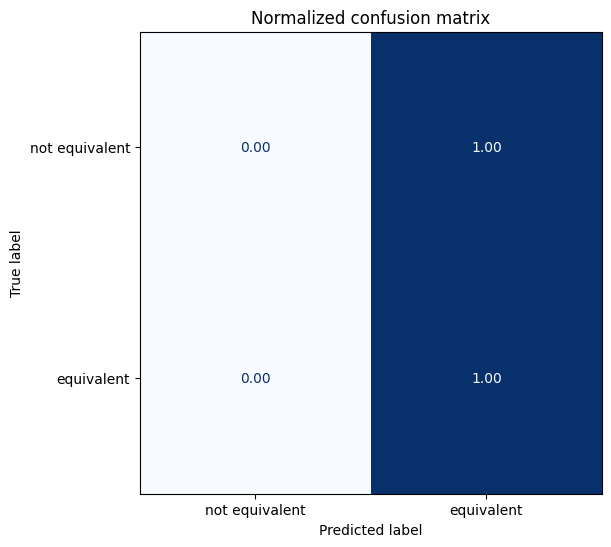

In [21]:
# plot the confusion matrix
## code here
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

## Train the LoRA variation of the RoBERTA Model
In this section we are going to fine tune the language model using the LoRA configuration. It will follow a similar procedure as done before.

In [22]:
# let us now get the LoRA confirguration
# get the lora configuration of the model
# in order to do this use lora_config and choose the appropriate rank

## code here
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=32, lora_alpha=1, lora_dropout=0.1)


In [23]:
# now create the pretained model using the RoBERTA path
# and wrap it around the lora configuration
# afterwards print out the number of trainable parameters
# what do you notice with the original roberta model?

## code here
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,771,778 || all params: 126,418,948 || trainable%: 1.4015


In [24]:
# in a similar way as before,
# write out the training arguments that you wish
# to use for the lora configuration of Roberta.

## code here
training_args = TrainingArguments(
    output_dir="ik_test/roberta-base-peft-p-tuning",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
# similarly as before write down the Trainer
# object and with your training arguments, lora model
# datasets, tokenizer, data collator, and compute metrics

## code here
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# train the model
## code here
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631100,0.533238,0.733913,0.826202
2,0.513500,0.413170,0.798841,0.860587
3,0.446300,0.353907,0.845797,0.883944
4,0.371300,0.352025,0.849275,0.891937


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

TrainOutput(global_step=460, training_loss=0.4759334730065387, metrics={'train_runtime': 167.1523, 'train_samples_per_second': 87.776, 'train_steps_per_second': 2.752, 'total_flos': 617951048233344.0, 'train_loss': 0.4759334730065387, 'epoch': 4.0})

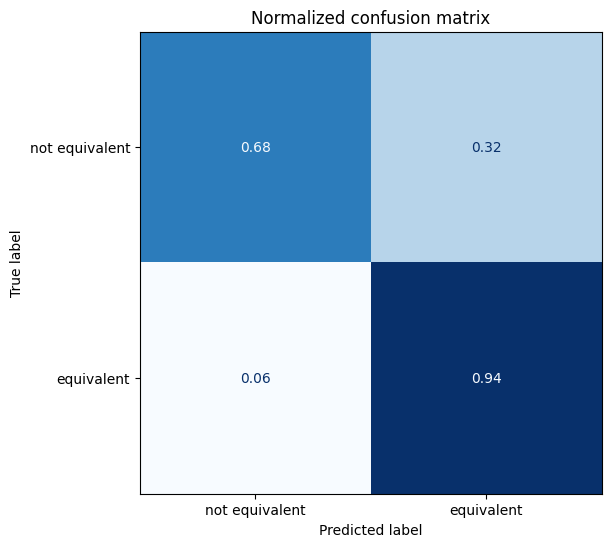

In [26]:
# get the training predictions
# as well as the test target outputs
# lastly plot the confusion matric

## code here
y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

Now we are ready to begin testing our LoRA model on test data that we generate ourselves. We are providing two sentences and the code in order to determine semantic similarity. Afterwards, you can test some yourselves.

In [27]:
# let's look at a specific example
# and see what the trained model will do on two samples
# that are not necessarily in the training or valiudation data

## here is the code to take in two sentences, tokenize them,
## and generate model logit outputs. Lastly, we are going to generate predictions
## for each classes.
def get_preds(sentence1, sentence2, classes=["not equivalent", "equivalent"]):
  inputs = tokenizer(sentence1,
                     sentence2,
                     truncation=True,
                     padding="longest",
                     return_tensors="pt").to("cuda")
  with torch.no_grad():
    outputs = trainer.model(**inputs).logits
    print(outputs)

  paraphrased_text = torch.softmax(outputs, dim=1).tolist()[0]
  for i in range(len(classes)):
      print(f"{classes[i]}: {int(round(paraphrased_text[i] * 100))}%")


## here are two sentences and we'd like to understand
## if the two sentences are equivalent
sentence1 = "Coast redwood trees are the tallest trees on the planet and can grow over 300 feet tall."
sentence2 = "The coast redwood trees, which can attain a height of over 300 feet, are the tallest trees on earth."
## run the get_preds function with these two sentences

## code here
get_preds(sentence1, sentence2)

tensor([[-2.3689,  2.2817]], device='cuda:0')
not equivalent: 1%
equivalent: 99%


In [28]:
## go ahead and chose two sentences and
## check if they are semantically equivalent
## what do you notice about the sentences you choose?

sentence1 = 'Howdy, my name is Harry and I like data science'
sentence2 = 'Howdy, my name is Albert and I like mathematics'
get_preds(sentence1, sentence2)

tensor([[-0.5693,  0.4411]], device='cuda:0')
not equivalent: 27%
equivalent: 73%
